# Intro

<img src="images/cells.jpg">
<p>This notebook demonstrates solving a clustering problem on the example of the <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">Breast Cancer Wisconsin (Diagnostic) Data Set</a>. The dataset contains features of benign and malignant cells. We will divide cells into 2 clusters and than check how well have this clusters matched the actual benign and malignant cells using the homogenity score.</p>

# Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "..")
import mymllib

%matplotlib inline
sns.set(font_scale=1.2)

PALETTE = "deep"

# Exploratory data analysis

## Download the dataset

In [2]:
columns = ["ID", "Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape",
           "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei",
           "Bland Chromatin", "Normal Nucleoli", "Mitoses", "Class"]
dataset = pd.read_table(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/" \
    "breast-cancer-wisconsin/breast-cancer-wisconsin.data",
    names=columns, sep=",", na_values = "?")
dataset.tail()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
694,776715,3,1,1,1,3,2.0,1,1,1,2
695,841769,2,1,1,1,2,1.0,1,1,1,2
696,888820,5,10,10,3,7,3.0,8,10,2,4
697,897471,4,8,6,4,3,4.0,10,6,1,4
698,897471,4,8,8,5,4,5.0,10,4,1,4


Let's set meaningful class names:

In [3]:
dataset.loc[dataset["Class"] == 2, "Class"] = "benign"
dataset.loc[dataset["Class"] == 4, "Class"] = "malignant"
dataset.tail()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
694,776715,3,1,1,1,3,2.0,1,1,1,benign
695,841769,2,1,1,1,2,1.0,1,1,1,benign
696,888820,5,10,10,3,7,3.0,8,10,2,malignant
697,897471,4,8,6,4,3,4.0,10,6,1,malignant
698,897471,4,8,8,5,4,5.0,10,4,1,malignant


## Check the dataset for missing data

As we can see, there are 16 rows in the dataset with missing data:

In [4]:
dataset.isna().sum()

ID                              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

For the purpose of demonstating the library it's OK to just remove this rows:

In [5]:
dataset = dataset.dropna()

## Select features and target

We select the Class column as the target value and all other columns (except ID) as features:

In [6]:
target_column = columns[-1]
feature_columns = columns[1:-1]

print("Target:", target_column)
print("Features:", feature_columns)

Target: Class
Features: ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']


## Train/Test split

Here we use a simple 80%/20% train/test split:

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=123)
test_dataset = dataset.drop(train_dataset.index)

print("Train dataset size:", train_dataset.shape[0])
print("Test dataset size:", test_dataset.shape[0])

Train dataset size: 546
Test dataset size: 137


## Classes examples count

Let's compare number of examples of each class:

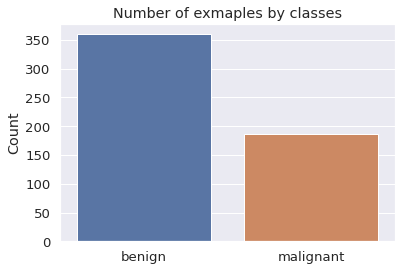

In [8]:
class_counts = train_dataset[target_column].value_counts()
plt.title("Number of exmaples by classes")
sns.barplot(class_counts.index, class_counts, palette=PALETTE)
_ = plt.ylabel("Count")

As we can see from the plot, a number of benign cells is approximately two times higher than a number of malignant ones. Having a single class with much more examples than in all other classes in extreme cases may cause a model to just predict this large class for any new example. However, in this dataset the differene between two classes is not big enough for this to happen and, even if it was enough, having a single cluster with elements from both classes won't satisfy the homogeneity part of the V-measure and such model will receive a low score.

## Visualization with PCA

To visualize the data, its dimensionality should be reduced to 2 dimension, which can be achieved with PCA. For PCA to work properly the data should be normalized:

In [9]:
data_scaler = mymllib.preprocessing.DataScaler().fit(train_dataset[feature_columns])
normalized_features = data_scaler.scale(train_dataset[feature_columns], by_std=False)

Let's run PCA. As we can see, the retained variance of two principal components is equal to 76.9%:

In [10]:
pca = mymllib.dim_reduction.PCA(2).fit(normalized_features)
print("Retained variance:", sum(pca.retained_variance))
features_2D = pca.transform(normalized_features)

Retained variance: 0.7692504170342155


The retained variance percentage is actually not very high, but since we perform dimensionality reduction just to visualize the data we can still make use of the compressed 2D representation (bearing in mind that it is not completely accurate):

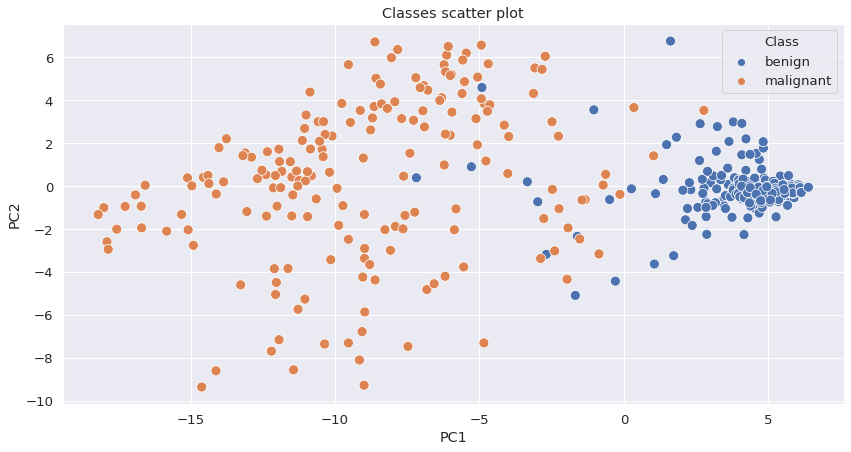

In [11]:
plt.figure(figsize=(14, 7))
plt.title("Classes scatter plot")
sns.scatterplot(x=features_2D[:, 0], y=features_2D[:, 1],
                hue=train_dataset[target_column], legend="full", palette=PALETTE,
                s=100)
plt.xlabel("PC1")
_ = plt.ylabel("PC2")

The scatter plot shows that at least most of the benign and malignant examples are indeed form two distinct groups, so we might be able to separate them from each other using a clustering algorithm.

# Model

We split both train and test datasets into X (features) and y (actual classes) to make them suitable for training and testing the model:

In [12]:
X_train = train_dataset[feature_columns]
y_train = train_dataset[target_column]

X_test = test_dataset[feature_columns]
y_test = test_dataset[target_column]

Now we need to normalize the data so that all features would have a mean of 0 and a variance of 1:

In [13]:
data_scaler = mymllib.preprocessing.DataScaler().fit(X_train)
X_train_norm = data_scaler.scale(X_train)
X_test_norm = data_scaler.scale(X_test)

To perform the clustering we will use the k-means algorithm. We will run the algorithm 100 times with different initial randomly selected cluster centroids and select a result from the best run. Running the algorithm only ones is not recommended for problems with a low clusters count, since it may stuck in a local minimum:

In [14]:
kmeans = mymllib.clustering.KMeans(clusters_count=2, runs_count=100)
kmeans.fit(X_train_norm)

To test the model we will use the above mentioned V-measure metric which returns the highest score (1.0) if clusters exactly match actual classes:

In [15]:
from sklearn.metrics import v_measure_score

def test_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print("Train V-measure score:", v_measure_score(y_train, y_train_pred))
    print("Test V-measure score:", v_measure_score(y_test, y_test_pred))

test_model(kmeans, X_train_norm, y_train, X_test_norm, y_test)

Train V-measure score: 0.7343959316777887
Test V-measure score: 0.6701434156746886


Let's also once again use the 2D representation of the data obtained with PCA to compare locations of clusters with actual classes (now using the test dataset):

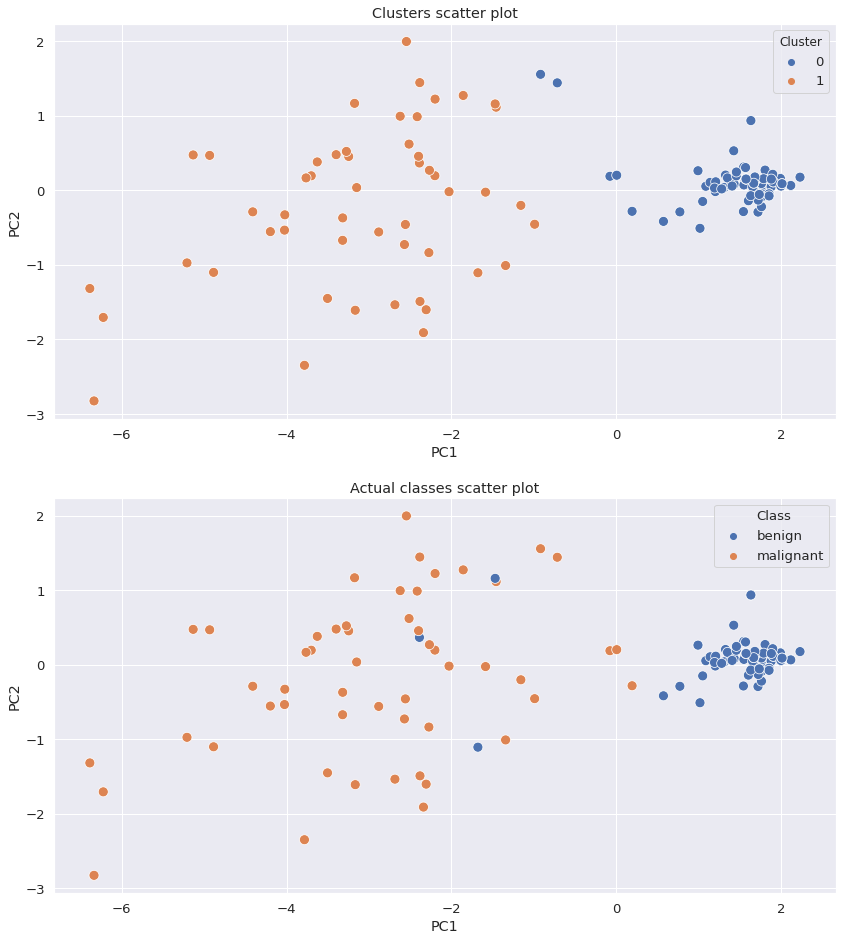

In [16]:
features_2D_test = pca.transform(X_test_norm)

plt.figure(figsize=(14, 16))

plt.subplot(211)
plt.title("Clusters scatter plot")
sns.scatterplot(x=features_2D_test[:, 0], y=features_2D_test[:, 1],
                hue=kmeans.predict(X_test_norm), legend="full", palette=PALETTE,
                s=100)
plt.legend(title="Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(212)
plt.title("Actual classes scatter plot")
sns.scatterplot(x=features_2D_test[:, 0], y=features_2D_test[:, 1],
                hue=test_dataset[target_column], legend="full", palette=PALETTE,
                s=100)
plt.xlabel("PC1")
_ = plt.ylabel("PC2")

As two plots above show, the model indeed have put some examples into wrong clusters which is in line with the V-measure scores being less than 1. However, we can see that the k-means was able to correctly find overall locations of benign and malignant examples, so it works as we would expect from the clustering algorithm.